In [68]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz

In [69]:
json_work={}

In [70]:
with open('filtered_nested_data_clust.json', 'r') as json_file:
    json_work=json.load(json_file)

In [71]:
X_named=[]
X=[]
for unit, sections in json_work.items():

    for section, problems in sections.items():
        for problem, step_kcs in problems.items():
            for tuple_key, tuples_list in step_kcs.items():
                n=0
                h,c,f=0,0,0
                for element in json_work[unit][section][problem][tuple_key]:
                    h+=element[0]
                    f+=element[1]
                    c+=element[2]
                    n+=1
                h=h/n
                c=c/n
                f=f/n
                
                concept_e=round(h/(f+h+c),4) if (f + h + c) != 0 else 0
                mistakes=round(f/(f+h+c),4) if (f + h + c) != 0 else 0
                
                # Extract step and skill from tuple_key
                step, skill = tuple_key.strip('()').replace("'", "").split(',', 1)

                X_named.append([problem, step, skill, concept_e, mistakes])
                X.append([concept_e, mistakes])
print(X_named[:3])
len(X_named)

[['PROP04', 'R1C1', ' nan', 0.0833, 0.1333], ['PROP04', 'R1C2', ' nan', 0.2517, 0.0979], ['PROP04', 'R3C1', ' Define Variable', 0.0901, 0.1081]]


14961

In [72]:
X=np.array(X)
X.shape


(14961, 2)

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import matplotlib.cm as cm

# Supongamos que X ya está definido como el dataset con forma (14961, 2)
# X = np.random.rand(14961, 2)  # Para demostración, utilizaré un dataset aleatorio si X no está definido

# Aplicar Fuzzy C-Means Clustering
n_clusters = 10  # Número de clusters
m = 2  # Parámetro de fuzziness

# Realizar el clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X.T, n_clusters, m, error=0.005, maxiter=1000, init=None
)



<Figure size 1200x800 with 0 Axes>

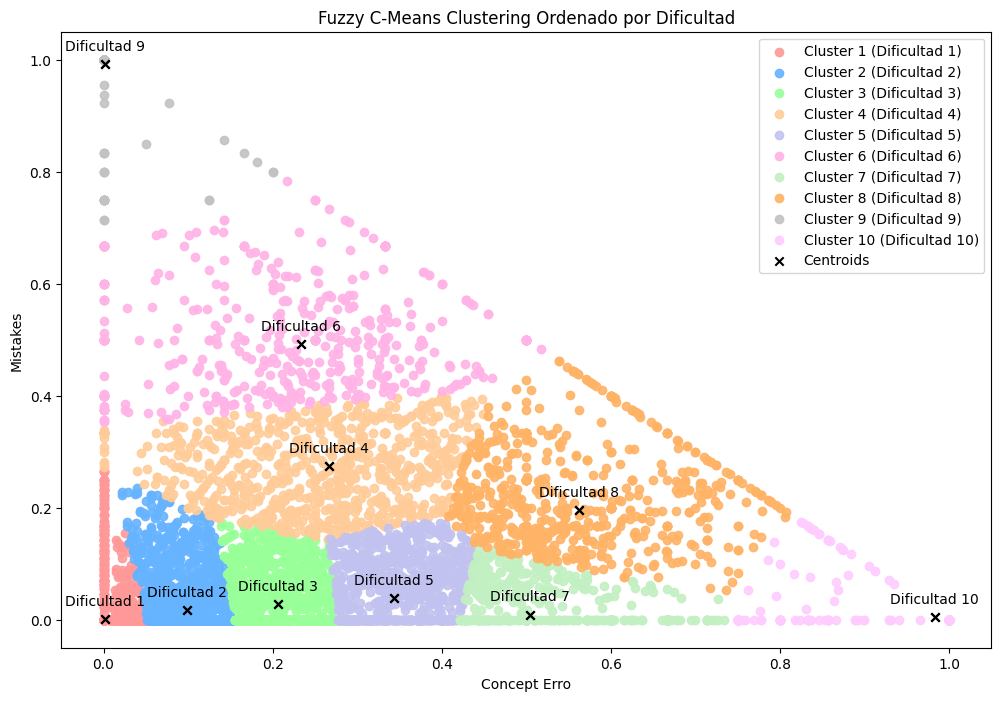

In [74]:
# Calcular la norma ajustada para cada centroide
adjusted_norms = []
for center in cntr:
    concept_e = center[0]  # Suponiendo que concept_e es el primer componente del centroide
    adjusted_concept_e = concept_e * 1.5  # Ajuste del valor concept_e
    norm = np.linalg.norm([adjusted_concept_e, center[1]])  # Calcular la norma ajustada
    adjusted_norms.append(norm)

# Ordenar los clusters por la norma ajustada (de menor a mayor dificultad)
sorted_indices = np.argsort(adjusted_norms)

# Asignar niveles únicos de dificultad a cada cluster
difficulty_levels = np.zeros(n_clusters)
for rank, i in enumerate(sorted_indices):
    difficulty_levels[i] = rank + 1  # Asignar nivel de dificultad único

# Asignar nivel de dificultad a cada punto en X
cluster_membership = np.argmax(u, axis=0)
difficulty_labels = np.zeros(X.shape[0])

for i, level in enumerate(difficulty_levels):
    difficulty_labels[cluster_membership == i] = level

# Añadir el nivel de dificultad a cada punto en X
X_with_difficulty = np.hstack((X, difficulty_labels.reshape(-1, 1)))

# Visualizar los clusters con el nivel de dificultad en los centroides
plt.figure(figsize=(12, 8))

pastel_colors = [
    '#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0',
    '#ffb3e6', '#c2f0c2', '#ffb366', '#c2c2c2', '#ffccff'
]

plt.figure(figsize=(12, 8))

# Graficar cada cluster
for rank, i in enumerate(sorted_indices):
    plt.scatter(X[cluster_membership == i, 0], X[cluster_membership == i, 1], 
                color=pastel_colors[rank], label=f'Cluster {rank + 1} (Dificultad {difficulty_levels[i]:.0f})', alpha=0.9)

    # Añadir etiquetas de dificultad a los centroides
    plt.scatter(cntr[i, 0], cntr[i, 1], marker='x', color='black')
    plt.annotate(f'Dificultad {difficulty_levels[i]:.0f}', (cntr[i, 0], cntr[i, 1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='black')

# Graficar los centroides
plt.scatter(cntr[:, 0], cntr[:, 1], marker='x', color='black', label='Centroids')


# Añadir etiquetas y leyenda
plt.title('Fuzzy C-Means Clustering Ordenado por Dificultad')
plt.xlabel('Concept Erro')
plt.ylabel('Mistakes')
plt.legend()
plt.show()


División 0: 7814 puntos
División 1: 1363 puntos
División 2: 1118 puntos
División 3: 1020 puntos
División 4: 862 puntos
División 5: 1300 puntos
División 6: 461 puntos
División 7: 270 puntos
División 8: 90 puntos
División 9: 663 puntos


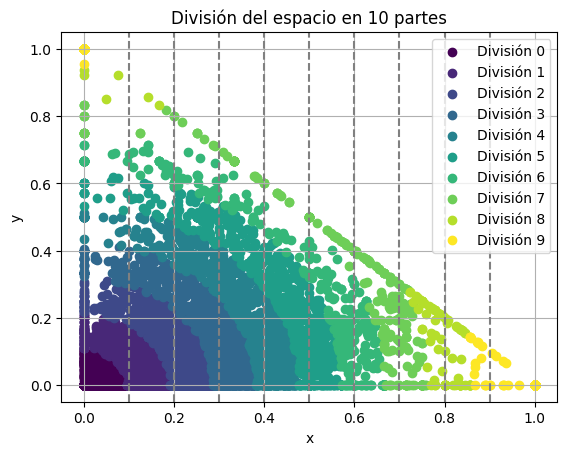

In [75]:
# Función para determinar a qué región pertenece un punto
from math import sqrt
def clasificar_punto(x, y):
    aux=sqrt(1.1*x**2+0.9*y**2)

    if aux < 0.1:
        return 0
    elif aux < 0.2:
        return 1
    elif aux < 0.3:
        return 2
    elif aux < 0.4:
        return 3
    elif aux < 0.5:
        return 4
    elif aux < 0.6:
        return 5
    elif aux < 0.7:
        return 6
    elif aux < 0.8:
        return 7
    elif aux < 0.9:
        return 8
    else:
        return 9

# Crear una lista para almacenar los puntos clasificados
puntos_divididos = [[] for _ in range(10)]
puntos_region=[]
for punto in X:
    x, y = punto
    region = clasificar_punto(x, y)
    puntos_divididos[region].append(punto)
    puntos_region.append(region)
    
# Mostrar los puntos divididos
for i, division in enumerate(puntos_divididos):
    print(f"División {i}: {len(division)} puntos")

# Graficar los puntos y las divisiones
colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i, division in enumerate(puntos_divididos):
    if division:
        division = np.array(division)
        plt.scatter(division[:, 0], division[:, 1], color=colors[i], label=f'División {i}')

# Añadir líneas divisorias
for i in range(1, 10):
    plt.axvline(x=i*0.1, color='gray', linestyle='--')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('División del espacio en 10 partes')
plt.grid(True)
plt.show()


División 0: 8373 puntos
División 1: 1084 puntos
División 2: 992 puntos
División 3: 724 puntos
División 4: 1299 puntos
División 5: 549 puntos
División 6: 541 puntos
División 7: 425 puntos
División 8: 175 puntos
División 9: 799 puntos


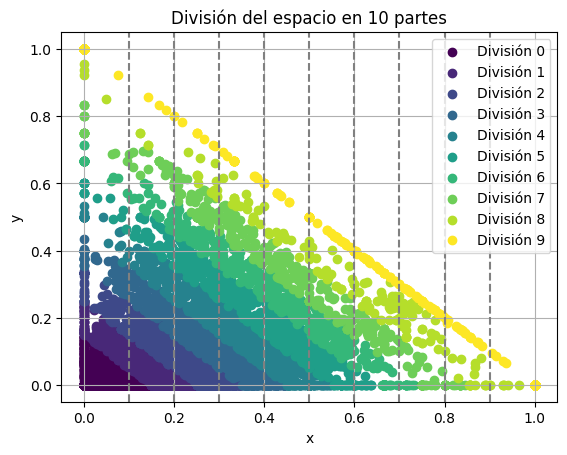

In [76]:
def clasificar_punto(x, y):
    aux=x+y

    if aux < 0.15:
        return 0
    elif aux < 0.25:
        return 1
    elif aux < 0.35:
        return 2
    elif aux < 0.45:
        return 3
    elif aux < 0.55:
        return 4
    elif aux < 0.65:
        return 5
    elif aux < 0.75:
        return 6
    elif aux < 0.85:
        return 7
    elif aux < 0.99:
        return 8
    else:
        return 9

# Crear una lista para almacenar los puntos clasificados
puntos_divididos = [[] for _ in range(10)]
puntos_region = []

# Clasificar los puntos
for punto in X:
    x, y = punto
    region = clasificar_punto(x, y)
    puntos_divididos[region].append(punto)
    puntos_region.append(region)

# Mostrar los puntos divididos
for i, division in enumerate(puntos_divididos):
    print(f"División {i}: {len(division)} puntos")

# Graficar los puntos y las divisiones
colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i, division in enumerate(puntos_divididos):
    if division:
        division = np.array(division)
        plt.scatter(division[:, 0], division[:, 1], color=colors[i], label=f'División {i}')

# Añadir líneas divisorias
for i in range(1, 10):
    plt.axvline(x=i*0.1, color='gray', linestyle='--')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('División del espacio en 10 partes')
plt.grid(True)
plt.show()

In [77]:
for i in range(len(X_named)):
    X_named[i].append(puntos_region[i]+1)


In [78]:
print(X_named[0])

['PROP04', 'R1C1', ' nan', 0.0833, 0.1333, 2]


In [83]:
dfsteps=pd.DataFrame(X_named,columns=['Problema','Step','Skills','E Conceptual','E Resolución','Dificultad'])
dfsteps.to_csv('Steps con dificultad.csv',index=False)